In [43]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.rasterization import build_rasterizer

import os
import copy
from itertools import cycle, combinations

In [2]:
os.environ['L5KIT_DATA_FOLDER'] = '../../dataset'
dm = LocalDataManager(None)

cfg = load_config_data('./config.yaml')
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


In [3]:
train_cfg = cfg['train_data_loader']
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()

In [4]:
def map_frame_array_to_dict(array):
    return dict(zip(['timestamp', 'agent_index_interval', 'ego_translation', 'ego_rotation'], array))

def map_scene_array_to_dict(array):
    return dict(zip(['frame_index_interval', 'host', 'start_time', 'end_time'], array))

def map_agent_array_to_dict(array):
    return dict(zip(['centroid', 'extent', 'yaw', 'velocity', 'track_id', 'label_probabilities'], array))

In [5]:
scenes = [map_scene_array_to_dict(s) for s in train_zarr.scenes]
frames = [map_frame_array_to_dict(f) for f in train_zarr.frames]
agents = [map_agent_array_to_dict(a) for a in train_zarr.agents]

In [6]:
def distance_from_center(agent1, agent2):
    '''
    Calculates the distance between the centroids of two agents
    @param agent1 - AgentDataset dictionary that represents first agent
    @param agent2 - AgentDataset dictionary that represents second agent
    @return - numpy float distance between the two agents' centroids
    '''
    return np.linalg.norm(agent1['centroid'] - agent2['centroid'])

In [7]:
def distance_from_edge(agent1, agent2):
    '''
    Calculates the distance between the closest edges of two agents
    @param agent1 - AgentDataset dictionary that represents first agent
    @param agent2 - AgentDataset dictionary that represents second agent
    @return - numpy float distance between two agents' closest edges
    '''
        
    # generate orthogonal axes for each agent
    a1_length_axis = agent1['extent'][1] / 2 * np.asarray([np.cos(agent1['yaw']), np.sin(agent1['yaw'])])
    a1_width_axis  = agent1['extent'][0] / 2 * np.asarray([np.sin(agent1['yaw']), np.cos(agent1['yaw'])])
    a2_length_axis = agent2['extent'][1] / 2 * np.asarray([np.cos(agent2['yaw']), np.sin(agent2['yaw'])])
    a2_width_axis  = agent2['extent'][0] / 2 * np.asarray([np.sin(agent2['yaw']), np.cos(agent2['yaw'])])
        
    # find two opposite corners of rectangles
    a1_corners = np.asarray([agent1['centroid'] + a1_length_axis * a + a1_width_axis * a for a in [-1, 1]])
    a2_corners = np.asarray([agent2['centroid'] + a2_length_axis * a + a2_width_axis * a for a in [-1, 1]])
    
    # convert corners into cartesian intervals
    a1_max = np.maximum(*a1_corners)
    a1_min = np.minimum(*a1_corners)
    a2_max = np.maximum(*a2_corners)
    a2_min = np.minimum(*a2_corners)
    
    # compute minkowski distance for rectangles
    y = np.maximum(0, np.maximum(a1_min - a2_max, a2_min - a1_max))
    
    return np.sum(np.abs(y) ** 2, axis=-1) ** (1/2)

In [8]:
distance_from_center(agents[1], agents[5])

53.94792262705793

In [9]:
distance_from_edge(agents[1], agents[5])

51.33004967277152

In [46]:
# playing around with scene 99
scene_i = 99
scene = scenes[scene_i]
scene

{'frame_index_interval': array([24590, 24838]),
 'host': 'host-a101',
 'start_time': 1571844710505151232,
 'end_time': 1571844735505151232}

In [11]:
# have this be numpy array from start
# agent embeddings for clustering
agent_embeddings = []
# dim 0 is frames, 1 agent

fii = scene['frame_index_interval']
for frame in frames[fii[0]: fii[1]]:
    frame_data = np.array([[0,0,0,0,0]])
    
    aii = frame['agent_index_interval']
    for agent in agents[aii[0]: aii[1]]:
        # concatenate these three different features to one embedding
        embedding = np.concatenate((agent['centroid'], agent['velocity'], [agent['yaw']]))
        frame_data = np.append(frame_data, [embedding], axis=0)
        
    agent_embeddings.append(frame_data[1:])

In [12]:
def normalize_frame(frame):
    '''
    Normalizes frame data generated above by applying (X - mean) / std
    @param frame -
    @return frame -
    '''
    ret = copy.deepcopy(frame)  # this is for safety, may not be neccesary
    
    means = frame.mean(axis=0)
    stds = frame.std(axis=0)
    
    for i in range(len(means)):
        # ensure no nans by replacing a column with zeros if std = 0
        if stds[i] != 0:
            ret[:, i] = (ret[:, i] - means[i]) / stds[i]
        else:
            ret[:, i] = np.zeros((len(frame)))

    return ret

def normalize_data(data):
    '''
    Copies and normalizes each frame in the data
    @param data -
    @return frame -
    '''
    # can also just define one new one of zeros
    ret = copy.deepcopy(data)  # for safety, may not be neccesary
    
    for i, each in enumerate(data):
        ret[i] = normalize_frame(each)
    return ret

In [13]:
n_data = normalize_data(agent_embeddings)

In [45]:
frame_i = 50
frame = n_data[frame_i]

In [15]:
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans

bandwidth = estimate_bandwidth(frame, quantile=0.3, n_samples=len(frame))

# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms = KMeans(n_clusters=8)

ms.fit(frame)

labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print(f"number of clusters {n_clusters_}")

number of clusters 8


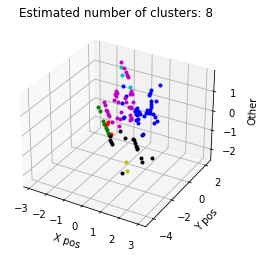

In [16]:
# index to change the data on the 'other axis'
# vx -> 2, vy -> 3, yaw -> 4
other = 4

plt.figure(1)
plt.clf()

ax = plt.axes(projection="3d")

ax.set_xlabel('X pos')
ax.set_ylabel('Y pos')
ax.set_zlabel('Other')

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    ax.plot(frame[my_members, 0], frame[my_members, 1], frame[my_members, other], col + '.')
    # ax.plot(cluster_center[0], cluster_center[1], cluster_center[3], 'o', markerfacecolor=col,
    #          markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [42]:
# get the agent indices associated with each cluster

cluster_to_indices = [None] * n_clusters_

for i, label in enumerate(labels):
    
    # if we have not created the array at the index yet, do so
    if not cluster_to_indices[label]:
        cluster_to_indices[label] = []
    
    cluster_to_indices[label].append(i)

In [56]:
# maps a cluster / label index to a distance matrix for the agents in that cluster
distance_matrices = []

# find appropriate indices
scene = scenes[scene_i]
frame = frames[scene['frame_index_interval'][0] + frame_i]
agent_baseline_index = frame['agent_index_interval'][0]

for cluster in cluster_to_indices:
    matrix = {}
    # choose every possibility of two agents in a cluster
    for comb in combinations(cluster, 2):
        agent1_index = agent_baseline_index + comb[0]
        agent2_index = agent_baseline_index + comb[1]
        
        agent1 = agents[agent1_index]
        agent2 = agents[agent2_index]
        
        edge_distance = distance_from_edge(agent1, agent2)
                
        if comb[0] not in matrix:
            matrix[comb[0]] = {}
        if comb[1] not in matrix:
            matrix[comb[1]] = {}
        
        matrix[comb[0]][comb[1]] = matrix[comb[1]][comb[0]] = edge_distance
        
    distance_matrices.append(matrix)

In [60]:
# this really needs better organization as the data goes on. must be easily attributed to a particular agent
# at a particular timestamp. needs good organization with time

In [61]:
distance_matrices

[{4: {7: 28.095513939857483,
   10: 16.85042178851172,
   13: 11.162966663345646,
   14: 25.074294179677963,
   15: 12.39359107238505,
   16: 33.46044736789283,
   17: 33.797219312217976,
   26: 54.126841464429454,
   27: 57.346148678907795,
   30: 59.33906180886829,
   35: 43.94946928379858,
   36: 17.326980268159645,
   39: 48.9467309100519,
   45: 49.59893441336943,
   46: 60.89703751769223,
   48: 60.427961040474365,
   50: 58.423914619367,
   51: 33.127738652884545,
   52: 26.574123710393906,
   55: 21.941244102243434,
   59: 18.79987871449635,
   63: 55.01785196091077,
   66: 31.17049896841035,
   71: 9.732991819230351,
   76: 16.093786147351253,
   78: 31.318503573536873,
   84: 60.127179917265416,
   86: 54.5417219294427,
   87: 39.91487784997895,
   93: 64.98837699090434,
   98: 73.33414249550555,
   99: 61.829153903588015,
   105: 63.69422969918117},
  7: {4: 28.095513939857483,
   10: 18.620198066689557,
   13: 16.726168495578044,
   14: 0.8952595889568329,
   15: 21.9102014